In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import (silhouette_score,
                             davies_bouldin_score,
                             calinski_harabasz_score)
import matplotlib.pyplot as plt
import io

In [2]:
# Load the dataset directly
df = pd.read_csv('../Data/06_filtered_customers_enhanced.csv')

display(df.head())

,customer_id,R,F,M,R_scaled,F_scaled,M_scaled,Status
0,12346,325,12,400.94,0.591999,0.443501,-0.273951,Keep
1,12347,2,8,4585.32,-0.949974,0.134057,0.379317,Keep
2,12348,75,5,1072.23,-0.601479,-0.098027,-0.169149,Keep
3,12349,18,4,4388.34,-0.873592,-0.175388,0.348565,Keep
4,12352,36,10,2849.84,-0.787661,0.288779,0.108373,Keep


In [3]:
# Get only numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", numeric_cols)

# Drop rows with all NaNs in numeric features
X = df[numeric_cols].dropna(how='all')

# Fill remaining NaNs with median
X = X.fillna(X.median(numeric_only=True))

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Numeric columns: ['customer_id', 'R', 'F', 'M', 'R_scaled', 'F_scaled', 'M_scaled']


In [4]:
def evaluate_kmeans(X_scaled, labels, model):
    n = X_scaled.shape[0]
    sample = min(3000, n)
    idx = np.random.RandomState(42).choice(n, size=sample, replace=False) if n > sample else np.arange(n)

    return {
        "inertia": model.inertia_,
        "silhouette": silhouette_score(X_scaled[idx], labels[idx]),
        "calinski_harabasz": calinski_harabasz_score(X_scaled, labels),
    }


In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.metrics import (silhouette_score,
                             davies_bouldin_score,
                             calinski_harabasz_score)
import io

# Load the dataset directly
df = pd.read_csv('../Data/06_filtered_customers_enhanced.csv')

# Get only numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", numeric_cols)

# Drop rows with all NaNs in numeric features
X = df[numeric_cols].dropna(how='all')

# Fill remaining NaNs with median
X = X.fillna(X.median(numeric_only=True))

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def evaluate_kmeans(X_scaled, labels, model):
    n = X_scaled.shape[0]
    sample = min(3000, n)
    idx = np.random.RandomState(42).choice(n, size=sample, replace=False) if n > sample else np.arange(n)

    return {
        "inertia": model.inertia_,
        "silhouette": silhouette_score(X_scaled[idx], labels[idx]),
        "calinski_harabasz": calinski_harabasz_score(X_scaled, labels),
    }


results = []

# Config 1
km1 = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=42)
labels1 = km1.fit_predict(X_scaled)
results.append({"model": "k=3, k-means++, n_init=10", **evaluate_kmeans(X_scaled, labels1, km1)})

# Config 2
km2 = KMeans(n_clusters=4, init='k-means++', n_init=20, random_state=42)
labels2 = km2.fit_predict(X_scaled)
results.append({"model": "k=4, k-means++, n_init=20", **evaluate_kmeans(X_scaled, labels2, km2)})

# Config 3
km3 = KMeans(n_clusters=5, init='random', n_init=10, random_state=42)
labels3 = km3.fit_predict(X_scaled)
results.append({"model": "k=5, random, n_init=10", **evaluate_kmeans(X_scaled, labels3, km3)})

# Show comparison
pd.DataFrame(results).sort_values("silhouette", ascending=False)

Numeric columns: ['customer_id', 'R', 'F', 'M', 'R_scaled', 'F_scaled', 'M_scaled']


,model,inertia,silhouette,calinski_harabasz
1,"k=4, k-means++, n_init=20",11466.778170,0.463041,2265.060626
0,"k=3, k-means++, n_init=10",14551.249443,0.437806,2227.262764
2,"k=5, random, n_init=10",9165.392072,0.382595,2391.708224


In [6]:
# Sort and display full comparison table
cmp_df = pd.DataFrame(results).sort_values("silhouette", ascending=False).reset_index(drop=True)
print("=== Model Accuracy Comparison (using clustering metrics) ===")
display(cmp_df)

# Select best model based on highest silhouette score
best_model_name = cmp_df.loc[0, "model"]
best_idx = results.index(cmp_df.loc[0].to_dict())
best_labels = [labels1, labels2, labels3][best_idx]

print(f"\n✅ Best model selected: {best_model_name}")


=== Model Accuracy Comparison (using clustering metrics) ===


,model,inertia,silhouette,calinski_harabasz
0,"k=4, k-means++, n_init=20",11466.778170,0.463041,2265.060626
1,"k=3, k-means++, n_init=10",14551.249443,0.437806,2227.262764
2,"k=5, random, n_init=10",9165.392072,0.382595,2391.708224



✅ Best model selected: k=4, k-means++, n_init=20


In [7]:
# Select best (highest silhouette)
best_idx = np.argmax([r["silhouette"] for r in results])
best_model = [km1, km2, km3][best_idx]
best_labels = [labels1, labels2, labels3][best_idx]

# Add cluster to original DataFrame
df_out = df.copy()
df_out["cluster"] = best_labels
df_out.head()

,customer_id,R,F,M,R_scaled,F_scaled,M_scaled,Status,cluster
0,12346,325,12,400.94,0.591999,0.443501,-0.273951,Keep,0
1,12347,2,8,4585.32,-0.949974,0.134057,0.379317,Keep,2
2,12348,75,5,1072.23,-0.601479,-0.098027,-0.169149,Keep,2
3,12349,18,4,4388.34,-0.873592,-0.175388,0.348565,Keep,2
4,12352,36,10,2849.84,-0.787661,0.288779,0.108373,Keep,2


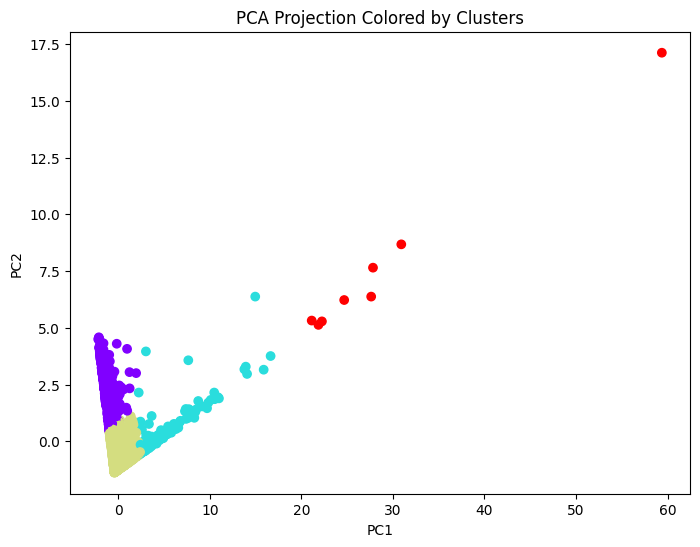

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=best_labels, cmap='rainbow')
plt.title('PCA Projection Colored by Clusters')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.savefig('../results/eda_visualization/kmeans_pca_clusters.png')
plt.show()

In [9]:
df_out.to_csv("../results/outputs/customer_segments_with_clusters.csv", index=False)
print("Saved to ../results/outputs/customer_segments_with_clusters.csv")

Saved to ../results/outputs/customer_segments_with_clusters.csv


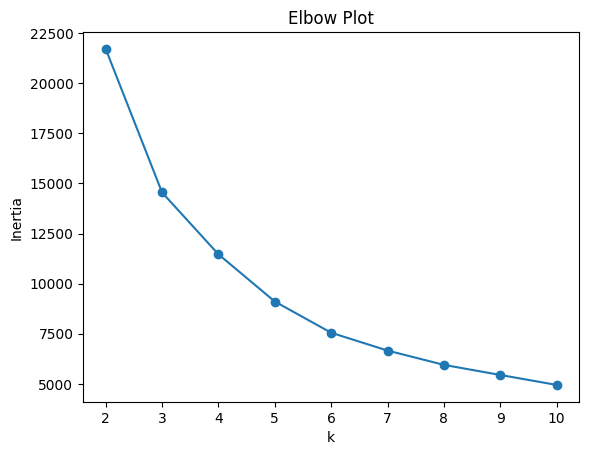

In [10]:
inertias = []
ks = range(2, 11)
for k in ks:
    km = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.plot(ks, inertias, marker='o')
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Plot")
plt.savefig('../results/eda_visualization/kmeans_elbow_plot.png')
plt.show()